In [8]:
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools
import time
import requests
import datetime

asset_count=5
ma_short=15
ma_long=50
pv_period=5

In [9]:
myassetlist = [
    'TSLA',
    'GOOG',
    'AAPL',
    'SPY',
    'XLI',
    'GME',
    'AMC',
    'BB',
    'NOK',
    'NAKD',
    'PSA',
    'KWEB'
]

In [10]:
df = yh(myassetlist)['Close'] # Get close prices

In [11]:
df

Symbols,TSLA,GOOG,AAPL,SPY,XLI,GME,AMC,BB,NOK,NAKD,PSA,KWEB
Date,,,,,,,,,,,,
2016-02-23,35.442001,695.849976,23.672501,192.320007,51.669998,29.440001,22.040001,7.26,6.08,239.009995,253.720001,33.049999
2016-02-24,35.799999,699.559998,24.025000,193.199997,51.700001,29.889999,22.549999,7.34,6.10,244.000000,249.919998,33.180000
2016-02-25,37.486000,705.750000,24.190001,195.539993,52.380001,29.959999,22.469999,7.26,6.20,250.000000,255.100006,32.340000
2016-02-26,38.068001,705.070007,24.227501,195.089996,52.450001,30.540001,23.299999,7.46,6.09,246.000000,254.039993,32.840000
2016-02-29,38.386002,697.770020,24.172501,193.559998,52.119999,30.820000,24.030001,7.81,6.03,247.990005,249.490005,32.730000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,816.119995,2104.110107,135.369995,392.640015,90.300003,52.400002,5.590000,13.04,4.17,1.440000,231.860001,102.199997
2021-02-16,796.219971,2121.899902,133.190002,392.299988,90.209999,49.509998,5.650000,12.21,4.13,1.290000,229.949997,103.529999
2021-02-17,798.150024,2128.310059,130.839996,392.390015,89.959999,45.939999,5.550000,11.32,4.11,1.350000,234.070007,103.559998


In [12]:
df.to_csv('data.csv') # run this if you wanna export to csv

In [26]:
# Rank the assets. Higher rank number means more bullish

In [23]:
# Existing Strategies

# Get 20 day returns and rank
ranked_momentum = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_momentum.columns = ['20_day_returns']
ranked_momentum['rank'] = ranked_momentum['20_day_returns'].rank()
ranked_momentum

,20_day_returns,rank
Symbols,,
GME,0.082069,12.0
TSLA,0.065838,11.0
AAPL,0.030908,10.0
NAKD,0.028838,9.0
BB,0.023598,8.0
KWEB,0.020010,7.0
GOOG,0.018968,6.0
AMC,0.018847,5.0
SPY,0.011846,4.0


In [24]:
#moving average short/long term
# (short ma - long ma) / long ma
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_assets.columns = ['MA_crossover']
ranked_ma_assets['rank'] = ranked_ma_assets.rank()
ranked_ma_assets

,MA_crossover,rank
Symbols,,
NAKD,1.029594,12.0
AMC,0.571870,11.0
GME,0.558353,10.0
BB,0.204225,9.0
KWEB,0.141155,8.0
GOOG,0.102263,7.0
TSLA,0.074171,6.0
NOK,0.024848,5.0
PSA,0.024319,4.0


In [25]:
#VPT indicator
# Reference: https://www.investopedia.com/terms/v/vptindicator.asp

vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_assets

ranked_pv_assets.columns = ['VPT_Indicator']
ranked_pv_assets['rank'] = ranked_pv_assets.rank()
ranked_pv_assets

,VPT_Indicator,rank
Symbols,,
KWEB,0.056478,12.0
SPY,0.002057,11.0
AMC,0.000063,10.0
NOK,-0.000160,9.0
TSLA,-0.002040,8.0
NAKD,-0.002494,7.0
GME,-0.006758,6.0
PSA,-0.009861,5.0
BB,-0.010752,4.0


# Combine strategies

In [15]:
combined = pd.DataFrame(pd.concat([ranked_momentum,ranked_ma_assets,ranked_pv_assets])['rank'])
combined = combined.reset_index()
combined = combined.groupby('Symbols').sum().sort_values('rank',ascending=False)

In [16]:
combined

,rank
Symbols,
GME,28.0
NAKD,28.0
KWEB,27.0
AMC,26.0
TSLA,25.0
BB,21.0
SPY,18.0
GOOG,16.0
NOK,16.0


<AxesSubplot:xlabel='Symbols'>

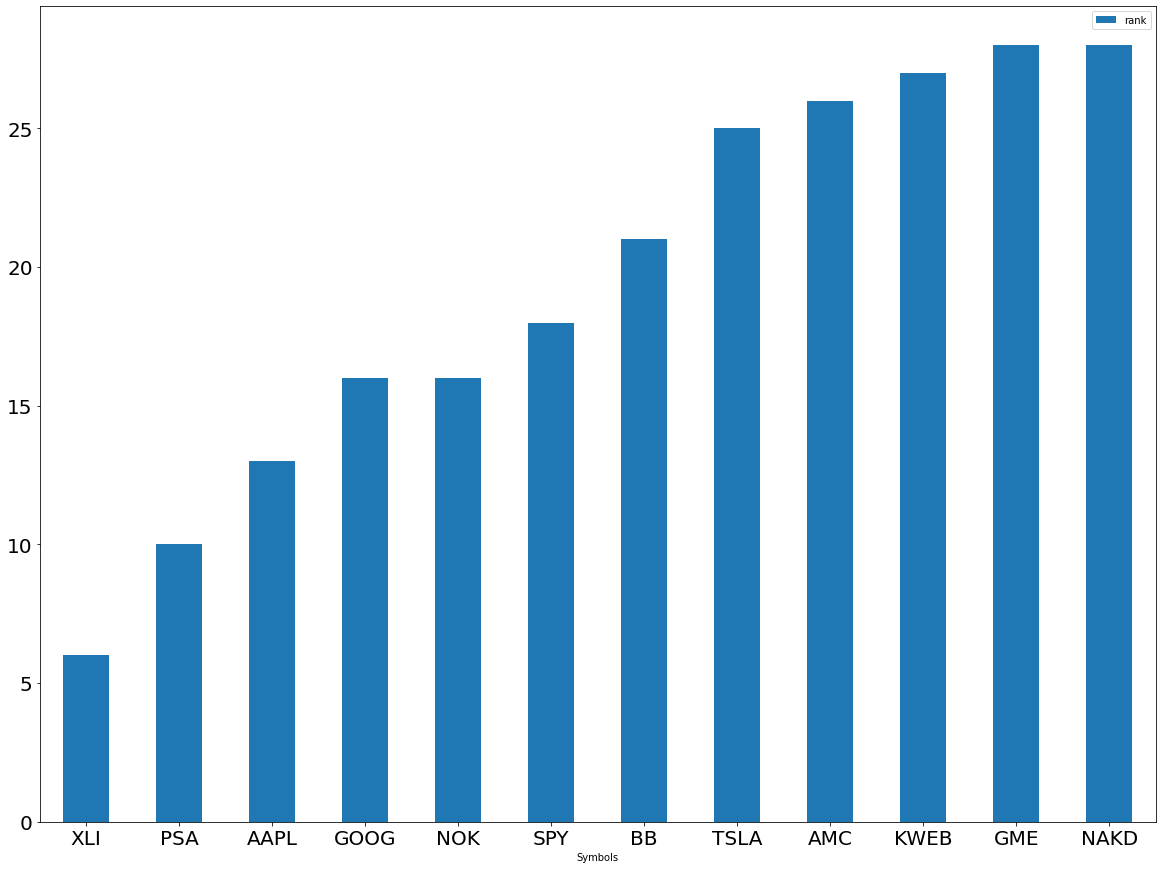

In [17]:
combined.sort_values(by='rank').plot.bar(figsize=(20,15), fontsize=20, rot=0)


# Telegram Notification


In [19]:
from telegram import *
from telegram.ext import *
import schedule
import pandas as pd

tf=pd.read_csv('telegram.csv')
key=tf.iloc[0,0]
chat_id= tf.iloc[0,1]

In [20]:
bot=Bot(key)
updater=Updater(key, use_context=True)

In [21]:
def get_stock(summary, key, chat_id):
    summary=str(summary)
    key=str(key)
    chat_id=str(chat_id)
    send_table='https://api.telegram.org/bot' + key + '/sendMessage?chat_id=' + chat_id + '&parse_mode=Markdown&text=' + summary
    response=requests.get(send_table)

In [22]:
get_stock(combined, key, chat_id)

In [ ]:
#while True:
 #   getStock(combined)
   # time.sleep(216000)


# Production Script
Do not touch this part

Assets here, separated by commas: SPY,GOOG,AAPL,QQQ
Use Internal Data csv file? - reply y/n: n
Results
         rank
Symbols      
QQQ      10.0
GOOG      8.0
AAPL      6.0
SPY       6.0


<AxesSubplot:xlabel='Symbols'>

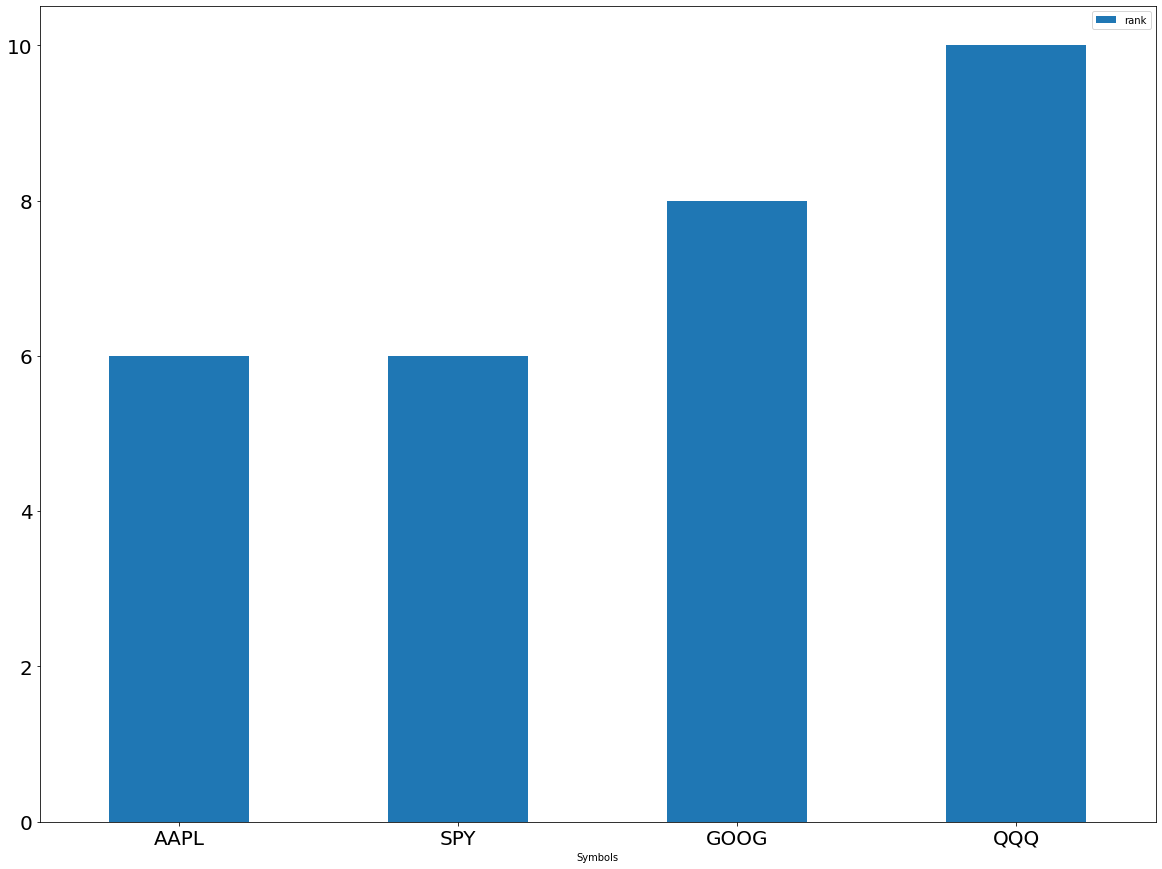

In [29]:
# %%writefile prod.py
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools

# Define variables and inputs:
asset_count=5
ma_short=15
ma_long=50
pv_period=5


myassetlist = input('Assets here, separated by commas: ')
myassetlist = myassetlist.split(',')

use_internal_data = input('Use Internal Data csv file? - reply y/n: ')


if use_internal_data == 'y':
    df = pd.read_csv('data.csv')[myassetlist]
else:
    df = yh(myassetlist)['Close'] # Get close prices
    df.combine_first(pd.read_csv('data.csv', index_col = 'Date', parse_dates=True)).to_csv('data.csv') #update local data source
    

# Get 20 day returns and rank
ranked_momentum = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_momentum.columns = ['20_day_returns']
ranked_momentum['rank'] = ranked_momentum['20_day_returns'].rank()
ranked_momentum

#moving average short/long term
# (short ma - long ma) / long ma
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_assets.columns = ['MA_crossover']
ranked_ma_assets['rank'] = ranked_ma_assets.rank()
ranked_ma_assets

#VPT indicator
# Reference: https://www.investopedia.com/terms/v/vptindicator.asp

vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_assets

ranked_pv_assets.columns = ['VPT_Indicator']
ranked_pv_assets['rank'] = ranked_pv_assets.rank()
ranked_pv_assets

combined = pd.DataFrame(pd.concat([ranked_momentum,ranked_ma_assets,ranked_pv_assets])['rank'])
combined = combined.reset_index()
combined.columns=['Symbols','rank']
combined = combined.groupby('Symbols').sum().sort_values('rank',ascending=False)

print('Results')
print(combined)
combined.sort_values(by='rank').plot.bar(figsize=(20,15), fontsize=20, rot=0)